### TorchText (Custom dataset and Translation).

In this notebook we are going to make use of the knowledge that we have gathered for the past weeks, on how to load our custom dataset from text files using torchtext and create a model that we will use to make prediction, translation from germany language to english language.

### Files
I have 6 files that are in my google drive which are:

```
1. train.de
2. train.en
3. test.de
4. test.en
5. val.de
6. val.en
```

Each file contain a line which correcpond to the a line in another laguage.


I'm going to make use of [this](https://github.com/CrispenGari/pytorch-python/blob/main/09_NLP/03_Sequence_To_Sequence/04_Packed_Padded_Sequences%2C_Masking%2C_Inference_and_BLEU.ipynb) notebook for the code. The purpose of this notebook is to show how we can load our own custom dataset from files.

### Imports

In [1]:
import torch
from torch import nn
from torch.nn  import functional as F
import spacy, math, random
import numpy as np
from torchtext.legacy import datasets, data
import time, os
from prettytable import PrettyTable
from matplotlib import pyplot as plt

### Setting the seeds

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Mounting the google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_path = '/content/drive/My Drive/NLP Data/seq2seq/manythings'
path_to_files = os.path.join(base_path, "German - English")
os.listdir(path_to_files)

['deu.txt',
 'valid.en',
 'train.de',
 'test.de',
 'valid.de',
 'test.en',
 'train.en',
 'multi30k']

### Loading tokenization models.

In [5]:
import spacy
spacy.cli.download('de_core_news_sm')
import de_core_news_sm, en_core_web_sm
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


### Preprocessing functions that will tokenize the sents

In [6]:
def tokenize_de(sent):
  return [tok.text for tok in spacy_de.tokenizer(sent)]

def tokenize_en(sent):
  return [tok.text for tok in spacy_en.tokenizer(sent)]

### Creating fields

In [7]:
SRC = data.Field(
    tokenize = tokenize_de,
    lower= True,
    init_token = "<sos>",
     eos_token = "<eos>",
     include_lengths =True
)
TRG = data.Field(
    tokenize = tokenize_en,
    lower= True,
    init_token = "<sos>",
     eos_token = "<eos>"
)

### Translation Dataset
We are using the `TranslationDataset` class to load our data from files. I got the idea from [this](https://pytorch.org/text/_modules/torchtext/datasets/translation.html) pytorch website.

In [8]:
train_data, valid_data, test_data = datasets.TranslationDataset.splits(
    exts=('.de', '.en'),
    path=path_to_files,
    train='train', validation='valid', test='test',
    fields = (SRC, TRG)
)

In [9]:
print(vars(train_data.examples[0]))

{'src': ['du', 'solltest', 'es', 'tun', '.'], 'trg': ['you', 'should', 'do', 'it', '.']}


In [10]:
print(vars(valid_data.examples[0]))

{'src': ['ich', 'hoffe', ',', 'wir', 'bekommen', 'weiße', 'weihnachten', '.'], 'trg': ['i', 'hope', 'we', 'have', 'a', 'white', 'christmas', '.']}


In [11]:
print(vars(test_data.examples[0]))

{'src': ['er', 'brachte', 'uns', 'traurige', 'nachrichten', '.'], 'trg': ['he', 'brought', 'us', 'sad', 'news', '.']}


### Counting examples

In [12]:
from prettytable import PrettyTable
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  table.title= "VISUALIZING SETS EXAMPLES"
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

column_names = ["SUBSET", "EXAMPLE(s)"]
row_data = [
        ["training", len(train_data)],
        ['validation', len(valid_data)],
        ['test', len(test_data)]
]
tabulate(column_names, row_data)

+-----------------------------+
|  VISUALIZING SETS EXAMPLES  |
+--------------+--------------+
| SUBSET       |   EXAMPLE(s) |
+--------------+--------------+
| training     |       240166 |
| validation   |         1207 |
| test         |         1213 |
+--------------+--------------+


### Building vocabulary

In [13]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

### Devices

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Iterators

In [27]:
BATCH_SIZE = 128
sort_key = lambda x: len(x.src)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key= sort_key,
    sort_within_batch = True
)

### Encoder Model.


In [16]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(input_dim, embedding_dim=emb_dim)
    self.gru = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src, src_len):
    embedded = self.dropout(self.embedding(src)) # embedded = [src len, batch size, emb dim]
    # need to explicitly put lengths on cpu!
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
    packed_outputs, hidden = self.gru(packed_embedded)
    outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
    return outputs, hidden

### Attention layer

In [17]:
class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super(Attention, self).__init__()
    self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim, 1, bias = False)

  def forward(self, hidden, encoder_outputs, mask):
    batch_size = encoder_outputs.shape[1]
    src_len = encoder_outputs.shape[0]
    # repeat decoder hidden state src_len times
    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
    encoder_outputs = encoder_outputs.permute(1, 0, 2)
    energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) # energy = [batch size, src len, dec hid dim]
    attention = self.v(energy).squeeze(2) # attention= [batch size, src len]
    attention = attention.masked_fill(mask == 0, -1e10)
    return F.softmax(attention, dim=1)

### Decoder

In [18]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
    super(Decoder, self).__init__()
    self.output_dim = output_dim
    self.attention = attention

    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.gru = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.fc = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, input, hidden, encoder_outputs, mask):
    input = input.unsqueeze(0) # input = [1, batch size]
    embedded = self.dropout(self.embedding(input)) # embedded = [1, batch size, emb dim]
    a = self.attention(hidden, encoder_outputs, mask)# a = [batch size, src len]
    a = a.unsqueeze(1) # a = [batch size, 1, src len]
    encoder_outputs = encoder_outputs.permute(1, 0, 2) # encoder_outputs = [batch size, src len, enc hid dim * 2]
    weighted = torch.bmm(a, encoder_outputs) # weighted = [batch size, 1, enc hid dim * 2]
    weighted = weighted.permute(1, 0, 2) # weighted = [1, batch size, enc hid dim * 2]
    rnn_input = torch.cat((embedded, weighted), dim = 2) # rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
    output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
    
    assert (output == hidden).all()
    embedded = embedded.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)

    prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1)) # prediction = [batch size, output dim]
    return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

In [19]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    self.src_pad_idx = src_pad_idx
  
  def create_mask(self, src):
    mask = (src != self.src_pad_idx).permute(1, 0)
    return mask
  def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
    """
    src = [src len, batch size]
    src_len = [batch size]
    trg = [trg len, batch size]
    teacher_forcing_ratio is probability to use teacher forcing
    e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
    """
    trg_len, batch_size = trg.shape
    trg_vocab_size = self.decoder.output_dim
        
    # tensor to store decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    """
    encoder_outputs is all hidden states of the input sequence, back and forwards
    hidden is the final forward and backward hidden states, passed through a linear layer
    """
    encoder_outputs, hidden = self.encoder(src, src_len)     
    # first input to the decoder is the <sos> tokens
    input = trg[0,:]
    mask = self.create_mask(src) # mask = [batch size, src len]
    for t in range(1, trg_len):
      # insert input token embedding, previous hidden state and all encoder hidden states and mask
      # receive output tensor (predictions) and new hidden state
      output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
      
      # place predictions in a tensor holding predictions for each token
      outputs[t] = output
      
      # decide if we are going to use teacher forcing or not
      teacher_force = random.random() < teacher_forcing_ratio
      
      # get the highest predicted token from our predictions
      top1 = output.argmax(1) 
      
      # if teacher forcing, use actual next token as next input
      # if not, use predicted token
      input = trg[t] if teacher_force else top1
    return outputs

### Model Instance

In [31]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = DEC_EMB_DIM = 256
ENC_HID_DIM = DEC_HID_DIM = 128
ENC_DROPOUT = DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20572, 256)
    (gru): GRU(256, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(11667, 256)
    (gru): GRU(512, 128)
    (fc): Linear(in_features=640, out_features=11667, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Initializing model weights

In [32]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
        nn.init.normal_(param.data, mean=0, std=0.01)
    else:
        nn.init.constant_(param.data, 0)   
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20572, 256)
    (gru): GRU(256, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=384, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(11667, 256)
    (gru): GRU(512, 128)
    (fc): Linear(in_features=640, out_features=11667, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Counting model parameters

In [33]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 16,357,011
Total tainable parameters: 16,357,011


### Optimizer and Criterion

In [34]:
optimizer = torch.optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)

### Train and evaluation functions

In [35]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        src = src.to(device)
        src_len = src_len.to(device)
        trg = batch.trg
        trg = trg.to(device)
        optimizer.zero_grad()
        output = model(src, src_len, trg)
        """
        trg = [trg len, batch size]
        output = [trg len, batch size, output dim]
        """
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        """
        trg = [(trg len - 1) * batch size]
        output = [(trg len - 1) * batch size, output dim]
        """
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
      for i, batch in enumerate(iterator):
          src, src_len = batch.src
          src = src.to(device)
          src_len = src_len.to(device)
          trg = batch.trg
          trg = trg.to(device)
          optimizer.zero_grad()
          output = model(src, src_len, trg, 0) ## Turn off the teacher forcing ratio.
          """
          trg = [trg len, batch size]
          output = [trg len, batch size, output dim]
          """
          output_dim = output.shape[-1]
          output = output[1:].view(-1, output_dim)
          trg = trg[1:].view(-1)
          """
          trg = [(trg len - 1) * batch size]
          output = [(trg len - 1) * batch size, output dim]
          """
          loss =  criterion(output, trg)
          epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Train loop

In [36]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [37]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'best-model.pt')
  
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 5m 39s
	Train Loss: 3.697 | Train PPL:  40.324
	 Val. Loss: 3.032 |  Val. PPL:  20.731
Epoch: 02 | Time: 5m 37s
	Train Loss: 2.195 | Train PPL:   8.983
	 Val. Loss: 2.364 |  Val. PPL:  10.635
Epoch: 03 | Time: 5m 37s
	Train Loss: 1.701 | Train PPL:   5.480
	 Val. Loss: 2.155 |  Val. PPL:   8.628
Epoch: 04 | Time: 5m 37s
	Train Loss: 1.479 | Train PPL:   4.390
	 Val. Loss: 2.054 |  Val. PPL:   7.800
Epoch: 05 | Time: 5m 36s
	Train Loss: 1.352 | Train PPL:   3.864
	 Val. Loss: 1.986 |  Val. PPL:   7.288
Epoch: 06 | Time: 5m 38s
	Train Loss: 1.260 | Train PPL:   3.526
	 Val. Loss: 1.975 |  Val. PPL:   7.210
Epoch: 07 | Time: 5m 38s
	Train Loss: 1.190 | Train PPL:   3.288
	 Val. Loss: 1.938 |  Val. PPL:   6.947
Epoch: 08 | Time: 5m 36s
	Train Loss: 1.136 | Train PPL:   3.115
	 Val. Loss: 1.920 |  Val. PPL:   6.821
Epoch: 09 | Time: 5m 34s
	Train Loss: 1.092 | Train PPL:   2.980
	 Val. Loss: 1.943 |  Val. PPL:   6.976
Epoch: 10 | Time: 5m 34s
	Train Loss: 1.067 | Train PPL

### Evaluating the best model.

In [38]:
model.load_state_dict(torch.load('best-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.024 | Test PPL:   7.567 |


### Model inference

In [39]:
import de_core_news_sm
def translate_sentence(sent, src_field, trg_field, mdoel, device, max_len=50):
  model.eval()

  if isinstance(sent, str):
    nlp = de_core_news_sm.load()
    tokens = [token.text.lower() for token in nlp(sent)]
  else:
    tokens = [token.lower() for token in sent]
  
  tokens = [src_field.init_token] + tokens + [src_field.eos_token]
  src_indexes = [src_field.vocab.stoi[token] for token in tokens]
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
  src_len = torch.LongTensor([len(src_indexes)])

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

  mask = model.create_mask(src_tensor)
  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
  attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

  for i in range(max_len):
    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    with torch.no_grad():
      output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

    attentions[i] = attention
    pred_token = output.argmax(1).item()
    trg_indexes.append(pred_token)

    if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
       break
  trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
  return trg_tokens[1:], attentions[:len(trg_tokens)-1]

### Model visualization

In [40]:
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### Getting a single example in the train set

In [41]:
example_idx = 0
src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['du', 'solltest', 'es', 'tun', '.']
trg = ['you', 'should', 'do', 'it', '.']


In [42]:
tokens, attention = translate_sentence(src,  SRC, TRG, model, device)
print(tokens)
tokens, attention = translate_sentence("zwei junge",  SRC, TRG, model, device)
print(tokens)

['you', 'should', 'do', 'it', '.', '<eos>']
['two', 'boy', 'boy', '.', '<eos>']


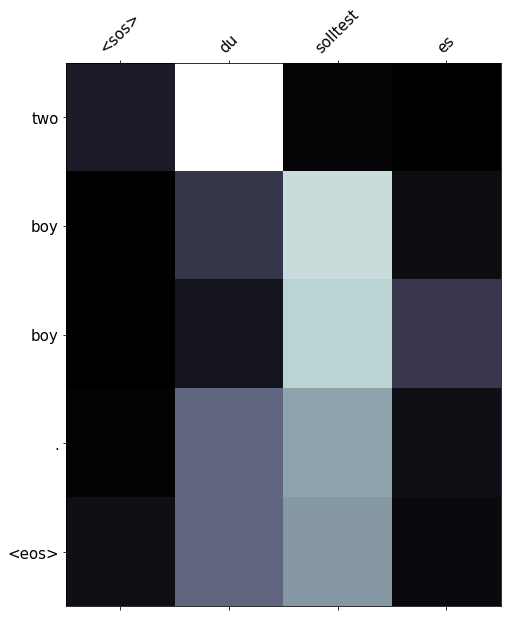

In [43]:
display_attention(src, tokens, attention)

### Getting a single example in the valid set

In [44]:
example_idx = 14
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['sind', 'sie', 'ein', 'religiöser', 'mensch', '?']
trg = ['are', 'you', 'a', 'religious', 'person', '?']


predicted trg = ['are', 'you', 'a', 'religious', 'person', '?', '<eos>']


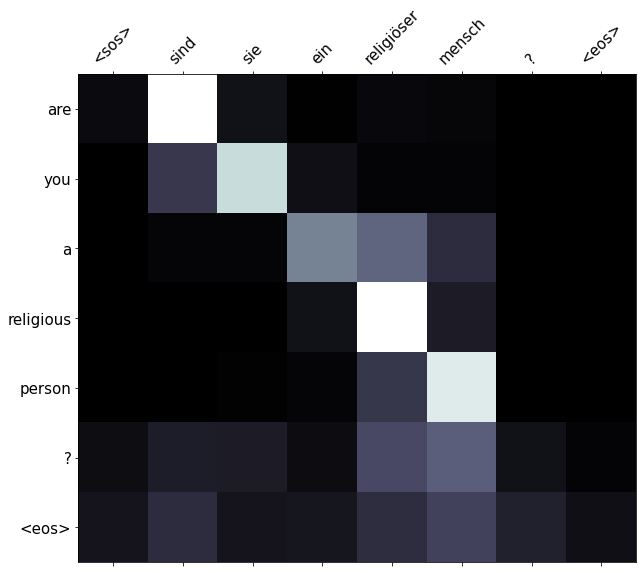

In [45]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

### Getting a single example in the test set

In [46]:
example_idx = 18
src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'wellen', 'verschlangen', 'das', 'boot', '.']
trg = ['the', 'waves', 'swallowed', 'up', 'the', 'boat', '.']


predicted trg = ['the', 'waves', 'crashed', 'the', 'boat', '.', '<eos>']


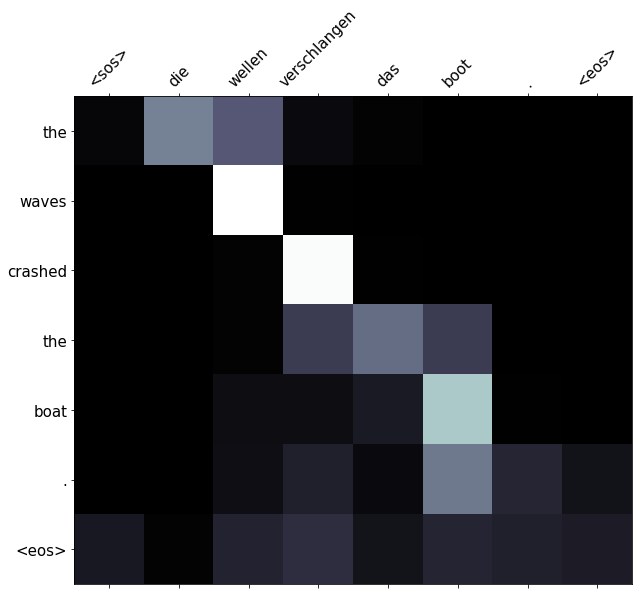

In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

### More translations

In [48]:
def tabulate_translations(column_names, data, title, max_characters=25):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'l'
  table.align[column_names[2]] = 'l'
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters, column_names[2]:max_characters}
  for row in data:
    table.add_row(row)
  print(table)
columns_names = [
    "German (real src sentence)", "English (the actual text)", "Translated (translated version)"
]
title = "GERMAN to ENGLISH TRANSLATOR"

def translation_table(src, SRC, TRG, model, device,columns_names, title,  max_characters=25,total_translations=10):
  rows_data = []
  for idx in range(total_translations):
    src = vars(test_data.examples[idx])['src']
    trg = vars(test_data.examples[idx])['trg']
    trasl, _ = translate_sentence(src, SRC, TRG, model, device)
    rows_data.append(
        [
        " ".join(src),
        " ".join(trg),
        " ".join(trasl).replace('<eos>', '')
        ], 
    )
    if idx+1 != total_translations:
      rows_data.append(["-" * max_characters, "-" * max_characters, "-" * max_characters ])

  tabulate_translations(columns_names, rows_data, title, max_characters)
translation_table(src, SRC, TRG, model, device,columns_names, title, max_characters=36)

+--------------------------------------------------------------------------------------------------------------------+
|                                            GERMAN to ENGLISH TRANSLATOR                                            |
+--------------------------------------+--------------------------------------+--------------------------------------+
| German (real src sentence)           | English (the actual text)            | Translated (translated version)      |
+--------------------------------------+--------------------------------------+--------------------------------------+
| er brachte uns traurige nachrichten  | he brought us sad news .             | he brought us a news .               |
| .                                    |                                      |                                      |
| ------------------------------------ | ------------------------------------ | ------------------------------------ |
| das mache ich nicht .                | i 'm no

### The BLUE SCORE


In [49]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        # cut off <eos> token
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)
        trgs.append([trg])
    return bleu_score(pred_trgs, trgs)

In [50]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 47.44
